Initiliaze and prepare all models

In [3]:
# Load model from checkpoint
import torch
import yaml
from models.decoder import architectures

with open("models/decoder/sequential_decoder_6_params.yaml") as file:
    params = yaml.safe_load(file)

#ckpt_file_path = "models/decoder/sequential_decoder_6.ckpt"
#model = architectures.LightningDecoderNet.load_from_checkpoint(ckpt_file_path, 
#                                                               inner_dims=params["inner_dims"], 
#                                                               seq_len=params["seq_len"], 
#                                                               learning_rate=params["learning_rate"])
#torch.save(model.state_dict(), "models/decoder/sequential_decoder_6.pth")

In [1]:
# ~~~~~~~~~~~~~~~~
# PyTorch Model

import torch
import yaml
from models.decoder import architectures

with open("models/decoder/sequential_decoder_length6_params.yaml") as file:
    params = yaml.safe_load(file)

decoder = architectures.LightningDecoderNet(params["inner_dims"], params["seq_len"], params["learning_rate"])
decoder.load_state_dict(torch.load("models/decoder/sequential_decoder_length6.pth"))
decoder.eval();

# ~~~~~~~~~~~~~~~~
# ESM

# To Do

### Data & Metrics

Specify data

In [4]:
from torch.utils import data
from data.gdm_dataset import GasDataSet

dataset = GasDataSet("data/30x25/test.pt", seq_len=params["seq_len"])

In [3]:
# Load data

import pickle

X_path = "models/esm/X.pkl"
X_all = pickle.load(open(X_path, "rb"))

y_path = "models/esm/y.pkl"
y_all = pickle.load(open(y_path, "rb" ) )


# Load ESM predictions

from scipy.io import loadmat

y_esm_path = "models/esm/preds.mat"
y_esm_all = loadmat(y_esm_path, verify_compressed_data_integrity=False)
y_esm_all = y_esm_all["export"]

Specify metrics

In [5]:
import gdm_metrics

rmse = {"decoder": 0,
        "esm": 0,
        }

kld = {"decoder": 0,
       "esm": 0,
       }

## Evaluation

In [6]:
from tqdm import tqdm

rmse = {"decoder": 0,
        }

kld = {"decoder": 0,
       }


dataloader = iter(data.DataLoader(dataset, shuffle=False, drop_last=True))

for X, y in tqdm(dataloader):
    with torch.no_grad(): 
        y_decoder = decoder(X.squeeze(2))
        rmse["decoder"] += gdm_metrics.rmse(y_decoder, y)
        kld["decoder"] += gdm_metrics.kld(y_decoder, y)
            
print(f"########\n# RMSE #\n########")
for elem in rmse:
    print(f"{elem}: \t {rmse[elem]/len(dataloader)}")
    
print(f"########\n# KL D #\n########")
for elem in kld:
    print(f"{elem}: \t {kld[elem]/len(dataloader)}")

100%|██████████████████████████████████████████████████████████████████████| 31800/31800 [03:19<00:00, 159.26it/s]

########
# RMSE #
########


NameError: name 'X_all' is not defined

In [9]:
import numpy as np
0.0664244294166565 * np.sqrt(len(dataloader)) 

11.845172577123666

In [8]:
print(f"########\n# RMSE #\n########")
for elem in rmse:
    print(f"{elem}: \t {rmse[elem]/len(dataloader)}")
    
print(f"########\n# KL D #\n########")
for elem in kld:
    print(f"{elem}: \t {kld[elem]/len(dataloader)}")

########
# RMSE #
########
decoder: 	 0.0664244294166565
########
# KL D #
########
decoder: 	 0.0029262625612318516


In [7]:
import numpy as np

rmse = {"decoder": 0,
        "esm": 0,
        }

kld = {"decoder": 0,
       "esm": 0,
       }

for i in tqdm(range(len(X_all))):
    X = X_all[i].unsqueeze(0)
    y = y_all[i].unsqueeze(0).unsqueeze(0)
    
    with torch.no_grad(): 
        y_decoder = decoder(X)
        rmse["decoder"] += gdm_metrics.rmse(y_decoder, y)
        kld["decoder"] += gdm_metrics.kld(y_decoder, y) 
    
    y_esm = torch.tensor(np.reshape(y_esm_all[i],[30,25], order="F"))
    y_esm = y_esm.unsqueeze(0).unsqueeze(0)
    rmse["esm"] += gdm_metrics.rmse(y_esm, y)
    kld["esm"] += gdm_metrics.kld(y_esm, y)
    
print(f"########\n# RMSE #\n########")
for elem in rmse:
    print(f"{elem}: \t {rmse[elem]/len(X_all)}")
    
print(f"########\n# KL D #\n########")
for elem in kld:
    print(f"{elem}: \t {kld[elem]/len(X_all)}")

100%|████████████████████████████████████| 30120/30120 [00:49<00:00, 605.02it/s]

########
# RMSE #
########
decoder: 	 0.07328736037015915
esm: 	 0.1408499926328659
########
# KL D #
########
decoder: 	 0.003549593733623624
esm: 	 0.013593791984021664


In [3]:
import numpy as np

# Correct RMSE calculation: 
print(f"Decoder RMSE: {0.07328736037015915 * 30120/np.sqrt(30120)}")
print(f"ESM RMSE: {0.1408499926328659 * 30120/np.sqrt(30120)}")

Decoder RMSE: 12.719105320877341
ESM RMSE: 24.44467752275151


In [38]:
i = 1000

X = X_all[i].unsqueeze(0)
y = y_all[i].unsqueeze(0).unsqueeze(0)
y_esm = torch.tensor(np.reshape(y_esm_all[i],[30,25], order="F"))
y_esm = y_esm.unsqueeze(0).unsqueeze(0)

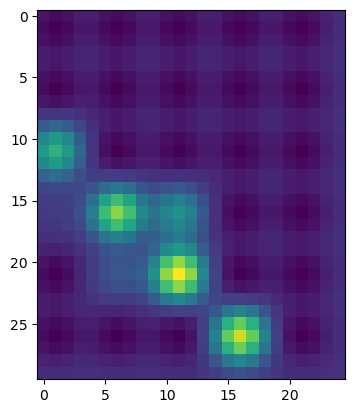

In [41]:
import matplotlib.pyplot as plt

plt.imshow(y_esm.squeeze())

In [17]:
import matplotlib.pyplot as plt

def plot_gdm(data, ax=None, vmin=None, vmax=None):
    if ax is None:
        fig, ax = plt.subplots();
        
    ax.axis("off");
    return ax.imshow(data.squeeze().detach().numpy(), vmin=vmin, vmax=vmax)


def plot_dict(input_dict, figsize=[5,5], cbar_base_col=0):
    """ Plots the input of a dict. The dict should contain GDM data.
    
    Input:
    input_dict: ...
    figsize: ... (automatically in the future?)
    cbar_base_col: Which col should be used as baseline vmin and vmax of plt.imshow.
    """
    
    rows = len(next(iter(input_dict.values())))
    cols = len(input_dict)

    fig, axes = plt.subplots(rows, len(input_dict), constrained_layout=True, figsize=figsize)  
    
    # Loop over rows (amount of samples)
    for row in range(rows):
        vmin=None
        vmax=None

        vmin = input_dict[list(input_dict.keys())[cbar_base_col]][row].min()
        vmax = input_dict[list(input_dict.keys())[cbar_base_col]][row].max()   
        
        # Loop over cols (amount of models)
        for col, i in zip(input_dict, range(cols)):
            try:
                # Try for multiple rows
                plot_gdm(input_dict[col][row].squeeze(), axes[row][i], vmin=vmin, vmax=vmax);
                if row == 0:
                    axes[row][i].set_title(col)
        
            except:
                # otherwise only single row
                plot_gdm(input_dict[col][row].squeeze(), axes[i], vmin=vmin, vmax=vmax);
                if row == 0:
                    axes[i].set_title(col)
    
    return fig, axes

In [21]:
X_list[0].shape

torch.Size([1, 20, 6, 5])

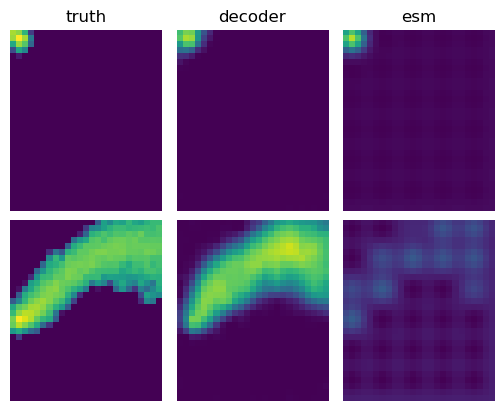

In [25]:
min_idx = 237
max_idx = 11277

X_list = [X_all[min_idx].unsqueeze(0), X_all[max_idx].unsqueeze(0)]
y_list = [y_all[min_idx].unsqueeze(0).unsqueeze(0), y_all[max_idx].unsqueeze(0).unsqueeze(0)]
y_esm_list = [torch.tensor(np.reshape(y_esm_all[min_idx],[30,25], order="F")),
              torch.tensor(np.reshape(y_esm_all[max_idx],[30,25], order="F"))]
#plot_gdm(y_list[1])


data = {
        "truth": y_list,
        "decoder": [decoder(x) for x in X_list],
        "esm": y_esm_list,
        #"decoderdenoise": [model_denoise(x.squeeze(1)) for x in X_list],
        #"kdm": [kdm.calculate(x.squeeze()) for x in X_list],
        #"gmrf": [gmrf.calculate(x.squeeze()) for x in X_list],
        }

fig, axes = plot_dict(data, [5,4]);

In [ ]:
from utils import plot_dict

X_list = [data_iter.next(), data_iter.next(), data_iter.next()]

data = {
        "input": X_list,
        "decoder": [model(x.squeeze(1)) for x in X_list],
        "decoderdenoise": [model_denoise(x.squeeze(1)) for x in X_list],
        "kdm": [kdm.calculate(x.squeeze()) for x in X_list],
        "gmrf": [gmrf.calculate(x.squeeze()) for x in X_list],
        }

fig, axes = plot_dict(data, [5,5]);